In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

## **학습 & 테스트 프로세스 요약**
| 단계 | 학습 (Train) | 테스트 (Test) |
|------|------------|-------------|
| **1. 데이터 입력** | CSV 파일 (이미 추출된 특징값) | 동영상 |
| **2. 특징 추출** | CSV에서 불러오기 | 동영상 → 프레임 추출 → 12개 묶음 → 특징 추출 |
| **3. 데이터 변환** | `(배치, 12, 5)` 형태로 변환 | `(1, 12, 5)` 형태로 변환 |
| **4. 모델 학습/예측** | LSTM 모델 학습 | LSTM 모델을 이용해 예측 |
| **5. 결과 저장** | `.pth` 파일로 저장 | 예측값 출력 |


# 1. 학습

1. 추출된 feature 로드 및 병합
2. LSTM Input 형식으로 변환
3. LSTM 학습

## 라이브러리 임포트

In [5]:
# !pip install koreanize-matplotlib

In [6]:
import os
import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import koreanize_matplotlib
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

## 1-2. LSTM Input 형식으로 변환

### Config 설정

In [7]:
config = {
    # RNN 설정
    "RNN_hidden_layers": 3,  # LSTM Layer 개수
    "RNN_hidden_nodes": 512,  # RNN Hidden State 크기
    "RNN_FC_dim": 256,  # RNN 최종 FC Layer 뉴런 개수
    "dropout_p": 0.2,  # 드롭아웃 비율

    # 학습 설정
    "k": 4,  # 클래스 개수 (normal, yawn, phonecall, text)
    "feature_num": 5, # Pitch, Yaw, EAR, MAR, Phone Detected
    "timestep": 12,
    "sliding_step": 6,
    "epochs": 100,  # 총 학습 횟수
    "batch_size": 32,  # 배치 크기
    "learning_rate": 5e-5,  # 학습률
    "log_interval": 5,  # 몇 번의 배치마다 로그 출력할지

    "action_names": ["normal", "phonecall", "text", "yawn"],  # 분류할 행동 리스트

    "use_cuda": torch.cuda.is_available(),
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),  # GPU 사용 가능 여부에 따라 설정
    "early_stopping_patience": 10,  # Early Stopping 기준 Epoch
    "reduce_lr_factor": 0.5,  # Learning Rate 감소 비율
    "reduce_lr_patience": 3,  # Learning Rate 감소 기준 Epoch

    "random_seed": 24,

    # 모델 결과 저장 경로
    "model_save_path": "/content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed",
    "train_result_path": "/content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/train_results",
}

In [8]:
def set_random_seed(seed):
    torch.manual_seed(seed)  # PyTorch CPU 연산에 대한 시드 설정
    torch.cuda.manual_seed(seed)  # CUDA 연산에 대한 시드 설정 (GPU 사용 시)
    torch.cuda.manual_seed_all(seed)  # 여러 GPU를 사용하는 경우 모든 GPU에 동일한 시드 설정
    np.random.seed(seed)  # NumPy 연산에 대한 시드 설정
    random.seed(seed)  # Python 기본 random 모듈의 시드 설정
    torch.backends.cudnn.deterministic = True  # CuDNN 연산의 결정론적 동작 보장
    torch.backends.cudnn.benchmark = False  # 성능 최적화 비활성화 (재현성 보장)

In [9]:
set_random_seed(config["random_seed"])

## 데이터 로드

### process_features

In [10]:
# 하이퍼파라미터
BATCH_SIZE = config['batch_size']
TIMESTEP = config['timestep']
FEATURE_DIM = config['feature_num'] # Pitch, Yaw, EAR, MAR, Phone Detected
NUM_CLASSES = config['k']  # normal, phonecall, text, yawn
SLIDING_STEP = config['sliding_step']
label_mapping = {"normal": 0, "phonecall": 1, "text": 2, "yawn": 3}
label_mapping_inverse = {0: "normal", 1: "phonecall", 2: "text", 3: "yawn"}

# 공통 로직: 데이터프레임 처리 및 시퀀스 생성
def process_features(df, sliding_labels=None, yaw_inversion_labels=None, is_train=True):
    """
    데이터프레임에서 시퀀스를 생성하는 함수.

    Args:
        df (pd.DataFrame): 입력 데이터프레임.
        sliding_labels (list): Sliding window 방식 적용할 라벨 리스트 (예: ['text', 'yawn']).
        is_train (bool): 학습용 데이터 여부. 테스트 데이터는 sliding step을 사용하지 않음.

    Returns:
        torch.Tensor: 시퀀스 데이터.
        torch.Tensor: 라벨 데이터.
        list: 메타데이터 (label, group_key, sequence_index).
        np.array: StratifiedGroupkFold 입력용 person ids
    """
    # label 인코딩
    df['label_encoded'] = df['label'].map(label_mapping)

    sequences = []
    labels = []
    person_ids = [] # cv 용
    metadata = []  # 메타데이터 저장 리스트

    for (label_encoded, group_key), group in df.groupby(['label_encoded', 'video_clip']):
        group = group.sort_values(by='frame')  # 프레임 순서대로 정렬
        features = group[["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]].values
        person_id = group_key.split("_")[0]

        # Sliding window 방식 적용 여부 결정
        if is_train and sliding_labels and label_mapping_inverse[label_encoded] in sliding_labels:
            step_size = SLIDING_STEP
        else:
            step_size = TIMESTEP

        # 원본 데이터를 처리
        for start_idx in range(0, len(features) - TIMESTEP + 1, step_size):
            end_idx = start_idx + TIMESTEP
            if end_idx <= len(features):
                sequences.append(features[start_idx:end_idx])
                labels.append(label_encoded)
                person_ids.append(person_id)
                metadata.append((label_encoded, group_key, start_idx))  # 메타데이터 추가

        # yaw_inversion_labels 해당
        if is_train and yaw_inversion_labels and label_mapping_inverse[label_encoded] in yaw_inversion_labels:
            inverted_features = features.copy()
            inverted_features[:, 1] = -inverted_features[:, 1]  # gaze_yaw 반전 (첫 번째 컬럼)

            for start_idx in range(0, len(inverted_features) - TIMESTEP + 1, step_size):
                end_idx = start_idx + TIMESTEP
                if end_idx <= len(inverted_features):  # 마지막 시퀀스가 seq_length에 맞는 경우만 처리
                    sequences.append(inverted_features[start_idx:end_idx])
                    labels.append(label_encoded)
                    person_ids.append(person_id)
                    metadata.append((label_encoded, group_key, start_idx))  # 메타데이터 추가

    # pytorch tensor 변환
    return (torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.long), metadata, np.array(person_ids))


# 학습용 데이터 로드 함수
def load_train_features(df):
    """
    학습용 데이터를 처리하여 시퀀스를 생성하는 함수.
    """
    sliding_labels = ['yawn']  # Sliding window 방식 적용할 라벨 리스트
    yaw_inversion_labels = ['text', 'yawn']
    return process_features(df, sliding_labels=sliding_labels, yaw_inversion_labels=yaw_inversion_labels, is_train=True)

# 테스트용 데이터 로드 함수
def load_test_features(df):
    """
    테스트용 데이터를 처리하여 시퀀스를 생성하는 함수.
    """
    return process_features(df, sliding_labels=None, is_train=False)

### train, text data load

In [11]:
train = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/train_processed.csv")
test = pd.read_csv("/content/drive/MyDrive/DMS/data/EDA/test_processed.csv")

In [12]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // config['timestep']
print("-----------Train-----------")
display(train_count)
print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // config['timestep']
display(test_count)

-----------Train-----------


,label,frame_count,clip_count
0,normal,65196,5433
1,phonecall,25296,2108
2,text,10044,837
3,yawn,4404,367


-----------Test-----------


,label,frame_count,clip_count
0,normal,14100,1175
1,phonecall,5688,474
2,text,2568,214
3,yawn,1212,101


In [13]:
sort_key = ["label", "video_name", "frame", "video_clip"]
features = ["gaze_pitch", "gaze_yaw", "EAR", "MAR", "phone_detected"]
train = train[sort_key + features]
test = test[sort_key + features]

### train에서 normal 1, 2 만 선택

In [14]:
print(f"before filtering normal: {len(train)}")
train = train[
    ((train['label'] == 'normal') &
     ((train['video_name'].str.split('_').str[-1] == 'part1') |
      (train['video_name'].str.split('_').str[-1] == 'part2'))) |
    (train['label'] != 'normal')
]
display(train.head())
print(f"after filtering normal: {len(train)}")

before filtering normal: 104940


,label,video_name,frame,video_clip,gaze_pitch,gaze_yaw,EAR,MAR,phone_detected
0,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000000.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.802380,-0.178544,0.188577,0.152621,0
1,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000001.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.258022,-0.444779,0.115461,0.098821,0
2,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000002.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,0.173530,-0.746606,0.101308,0.080448,0
3,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000003.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.022168,-0.725515,0.101270,0.099019,0
4,normal,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,frame000004.jpg,gB-10(File10)_s1_face_2019-03-11-15_24_54_10_0...,-0.187156,-0.672688,0.110530,0.118148,0


after filtering normal: 71592


In [15]:
train.dropna(inplace=True)
test.dropna(inplace=True)
print("학습 데이터: ", train.shape)
print("테스트 데이터: ", test.shape)

학습 데이터:  (71520, 9)
테스트 데이터:  (23544, 9)


In [16]:
train_count = train.groupby('label')['label'].count().reset_index(name='frame_count')
train_count['clip_count'] = train_count['frame_count'] // 12
train_count['ratio'] = round(train_count['clip_count'] / train_count['clip_count'].sum() * 100, 1) # 비율 계산
print("-----------Train-----------")
display(train_count)

print("-----------Test-----------")
test_count = test.groupby('label')['label'].count().reset_index(name='frame_count')
test_count['clip_count'] = test_count['frame_count'] // 12
test_count['ratio'] = round(test_count['clip_count'] / test_count['clip_count'].sum() * 100, 1) # 비율 계산
display(test_count)

-----------Train-----------


,label,frame_count,clip_count,ratio
0,normal,31800,2650,44.5
1,phonecall,25272,2106,35.3
2,text,10044,837,14.0
3,yawn,4404,367,6.2


-----------Test-----------


,label,frame_count,clip_count,ratio
0,normal,14100,1175,59.9
1,phonecall,5664,472,24.1
2,text,2568,214,10.9
3,yawn,1212,101,5.1


In [17]:
# Train, Test dataset
train_features, train_labels, train_meta, train_personids = load_train_features(train)
test_features, test_labels, test_meta, test_personids = load_test_features(test)

In [18]:
# 레이블 개수 및 비율 계산
label_counts = pd.Series(train_labels).value_counts()
label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100  # 비율 계산 (백분율)

# 매핑된 결과 출력
print("레이블 분포:")
print("-----------Train-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}개 ({label_ratios[label]:.2f}%)")

# 레이블 개수 및 비율 계산
label_counts = pd.Series(test_labels).value_counts()
label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100  # 비율 계산 (백분율)

print("-----------Test-----------")
for label, count in label_counts.items():
    print(f"{label_mapping_inverse[label]}: {count}개 ({label_ratios[label]:.2f}%)")

레이블 분포:
-----------Train-----------
normal: 2650개 (34.90%)
phonecall: 2106개 (27.73%)
text: 1674개 (22.04%)
yawn: 1164개 (15.33%)
-----------Test-----------
normal: 1175개 (59.89%)
phonecall: 472개 (24.06%)
text: 214개 (10.91%)
yawn: 101개 (5.15%)


### 데이터 둘러보기 - 시각화
- 훈련 데이터 개수
- 테스트 데이터 개수
- 타겟값 분포

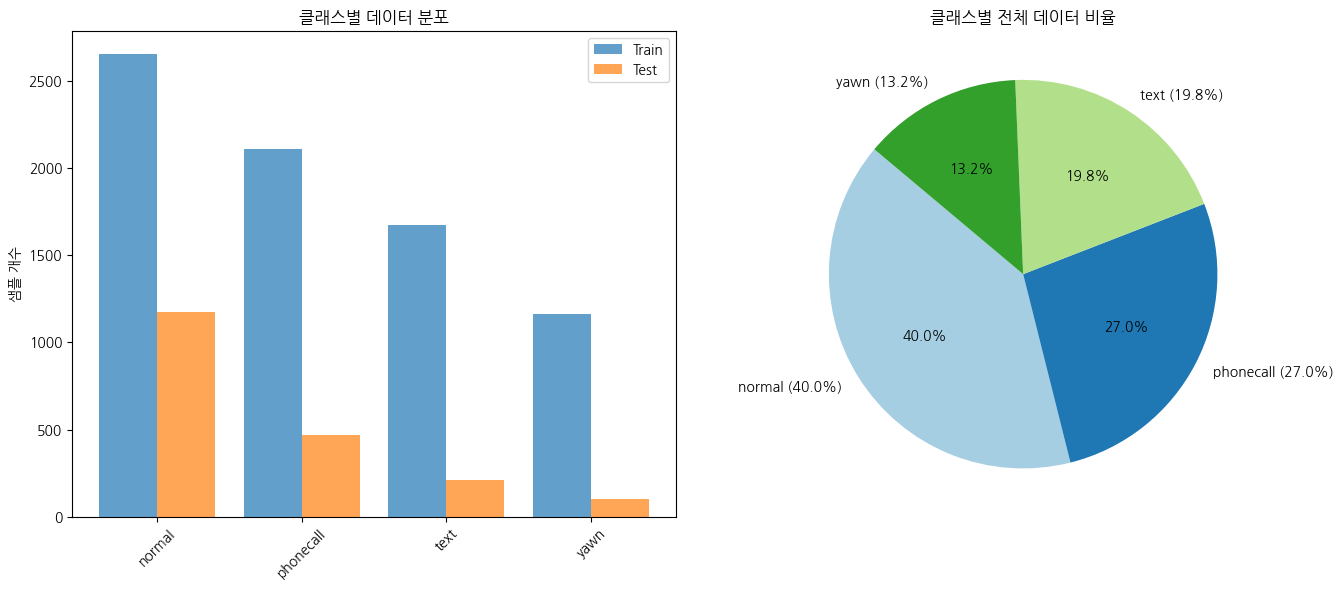

In [19]:
def visualize_data_distribution(train_labels, test_labels, label_mapping_inverse):
    """
    훈련/테스트 데이터의 레이블 분포를 시각화하는 함수.

    Args:
        train_labels (list or pd.Series): 훈련 데이터의 레이블.
        test_labels (list or pd.Series): 테스트 데이터의 레이블.
        label_mapping_inverse (dict): 정수형 레이블을 문자열로 매핑하는 딕셔너리.
    """
    # 레이블 개수 및 비율 계산
    train_label_counts = pd.Series(train_labels).value_counts()
    train_label_ratios = pd.Series(train_labels).value_counts(normalize=True) * 100

    test_label_counts = pd.Series(test_labels).value_counts()
    test_label_ratios = pd.Series(test_labels).value_counts(normalize=True) * 100

    # 클래스 이름 매핑
    class_names = [label_mapping_inverse[label] for label in train_label_counts.index]

    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # (왼쪽) Bar Chart - 클래스별 샘플 개수 비교
    x = np.arange(len(class_names))
    width = 0.4

    axes[0].bar(x - width / 2, train_label_counts.values, width, label="Train", alpha=0.7)
    axes[0].bar(x + width / 2, test_label_counts.values, width, label="Test", alpha=0.7)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(class_names, rotation=45)
    axes[0].set_ylabel("샘플 개수")
    axes[0].set_title("클래스별 데이터 분포")
    axes[0].legend()

    # (오른쪽) Pie Chart - 전체 데이터 비율
    total_counts = train_label_counts + test_label_counts
    total_ratios = total_counts / total_counts.sum() * 100

    axes[1].pie(
        total_counts,
        labels=[f"{class_names[i]} ({total_ratios[i]:.1f}%)" for i in range(len(class_names))],
        autopct="%1.1f%%",
        startangle=140,
        colors=plt.cm.Paired.colors,
    )
    axes[1].set_title("클래스별 전체 데이터 비율")

    plt.tight_layout()
    plt.show()

visualize_data_distribution(train_labels, test_labels, label_mapping_inverse)

### DataLoader

In [20]:
# DataLoader 설정
params = {
    "batch_size": config["batch_size"],
    "shuffle": True,
    "num_workers": 4,
    "pin_memory": True,
    "persistent_workers": True,
    "prefetch_factor": 2,
} if config["use_cuda"] else {}

In [21]:
# DataLoader 생성 (배치 단위로 데이터를 나누기 위해 사용)
train_dataset = TensorDataset(train_features, train_labels)
test_dataset = TensorDataset(test_features, test_labels)

train_loader = DataLoader(train_dataset, **params)
test_loader = DataLoader(test_dataset, **params)

# 배치 단위 확인
for x_batch, y_batch in train_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

for x_batch, y_batch in test_loader:
    print("Batch Shape:", x_batch.shape, y_batch.shape)  # (batch_size, timestep, feature), (batch_size,)
    break  # 한 배치만 확인

Batch Shape: torch.Size([32, 12, 5]) torch.Size([32])
Batch Shape: torch.Size([32, 12, 5]) torch.Size([32])


In [ ]:
# # Train, Test 라벨별 개수 확인
# labels = train_labels.to(torch.long)#  Long 타입으로 변환
# counts = torch.bincount(labels)
# print(counts)

# labels = valid_labels.to(torch.long)#  Long 타입으로 변환
# counts = torch.bincount(labels)
# print(counts)

# labels = test_labels.to(torch.long)
# counts = torch.bincount(labels)
# print(counts)

## 1-3. LSTM 학습

In [22]:
# LSTM 모델 정의
class DecoderRNN(nn.Module):
    def __init__(self, config):
        super(DecoderRNN, self).__init__()

        self.RNN_input_size = config['feature_num']  # 특징 개수
        self.h_RNN_layers = config["RNN_hidden_layers"]
        self.h_RNN = config["RNN_hidden_nodes"]
        self.h_FC_dim = config["RNN_FC_dim"]
        self.drop_p = config["dropout_p"]
        self.num_classes = config["k"]

        self.LSTM = nn.LSTM(
            input_size=self.RNN_input_size,
            hidden_size=self.h_RNN,
            num_layers=self.h_RNN_layers,
            batch_first=True,
        )

        self.fc1 = nn.Linear(self.h_RNN, self.h_FC_dim)
        self.fc2 = nn.Linear(self.h_FC_dim, self.num_classes)
        self.dropout = nn.Dropout(p=self.drop_p)

    def forward(self, x_RNN):
        self.LSTM.flatten_parameters()
        RNN_out, _ = self.LSTM(x_RNN, None)

        # FC layers
        x = self.fc1(RNN_out[:, -1, :])  # 마지막 타임스텝a 사용
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x  # CrossEntropyLoss 사용 (Softmax 없음)

### optimizer

In [23]:
def get_optimizer(model, config):
    return optim.Adam(model.parameters(), lr=config["learning_rate"])
criterion = nn.CrossEntropyLoss()

### 학습률 감소 스케줄러 설정
Test Loss 기준
- factor: 0.5, 학습률 50% 감소
- verbose: True, 감소된 경우 로그 출력

In [24]:
def get_scheduler(optimizer, config):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=config["reduce_lr_factor"],
        patience=config["reduce_lr_patience"],
    )

### Early Stopping 설정

In [25]:
early_stopping_patience = config["early_stopping_patience"]
best_loss = np.inf
patience_counter = 0

## 학습 진행

- Mixed Precision Training 유지 (torch.cuda.amp.autocast() + GradScaler())
-  Gradient Clipping 추가 (torch.nn.utils.clip_grad_norm_()) → 폭발적인 기울기(Gradient Explosion) 방지
- 모델 저장 기능 추가 (torch.save()) → Best Loss 갱신 시 자동 저장
- 학습률 스케줄러 로깅 추가 → ReduceLROnPlateau가 작동했는지 확인 가능

In [26]:
def save_best_model(model, optimizer, epoch, best_loss, save_path):
    """Validation Loss가 가장 낮을 때만 모델을 저장하는 함수"""
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")  # 날짜 가져오기
    model_filename = f"{save_path}/best_model_{today_date}.pth"  # 저장 파일명

    # 기존 최적 모델 삭제 (이전 모델 유지 안 함)
    if os.path.exists(model_filename):
        os.remove(model_filename)

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }, model_filename)

    print(f"💾 Best Model Updated! Saved at {model_filename} (Loss: {best_loss:.4f})")

def save_training_results(
        epoch_train_losses,
        epoch_train_scores,
        epoch_test_losses,
        epoch_test_scores,
        save_path="./",
        ):
    """
    학습 과정의 손실(loss)과 정확도(score)를 저장하는 함수
    """
    os.makedirs(save_path, exist_ok=True)

    np.save(
        os.path.join(save_path, "LSTM_epoch_training_losses.npy"),
        np.array(epoch_train_losses),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_tsave_path, raining_scores.npy"),
        np.array(epoch_train_scores),
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_loss.npy"), np.array(epoch_test_losses)
    )
    np.save(
        os.path.join(save_path, "LSTM_epoch_test_score.npy"),
        np.array(epoch_test_scores),
    )

### epoch마다 validation data로 성능평가
- 다음 기술을 적용하는 기준: Validation data Loss
    - Early Stopping
    - 학습률 감소 스케줄러
    - 모델 저장 (Best Loss 갱신 시)

In [27]:
def ensure_directory_exists(path):
    """주어진 경로의 폴더가 없으면 생성하는 함수"""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"📂 Directory created: {path}")

In [28]:
# ✅ 경로 자동 생성 (존재하지 않으면 생성)
ensure_directory_exists(os.path.dirname(config["model_save_path"]))  # 모델 저장 폴더
ensure_directory_exists(config["train_result_path"])  # 학습 결과 폴더

📂 Directory created: /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/train_results


In [29]:
# Mixed Precision Training을 위한 GradScaler 설정
scaler = torch.amp.GradScaler()

def train_model(model, train_loader, optimizer, criterion, scheduler, config):
    """
    Mixed Precision Training & Early Stopping 적용 학습 함수
    """
    model.to(config["device"])

    best_loss = np.inf  # Best Loss 초기화
    patience_counter = 0  # Early Stopping 카운터
    epoch_losses, epoch_scores = [], []  # Loss 및 Accuracy 저장용 리스트

    for epoch in range(config["epochs"]):
        model.train()
        losses, scores = [], []
        total_samples = 0

        # tqdm을 사용하여 학습 진행률 표시
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}", leave=True)

        for batch_idx, (X, y) in enumerate(progress_bar):
            X, y = X.to(config["device"]), y.to(config["device"]).long()

            # Mixed Precision Training 적용
            total_samples += X.size(0)
            optimizer.zero_grad(set_to_none=True)

            with torch.amp.autocast('cuda'): # 자동 Mixed Precision 사용
                output = model(X)  # LSTM 모델 Forward Pass
                loss = criterion(output, y)

            scaler.scale(loss).backward()  # Mixed Precision Backpropagation
            scaler.step(optimizer)  # 옵티마이저 업데이트
            scaler.update()  # Scaler 업데이트

            losses.append(loss.item())

            # 정확도 계산
            y_pred = torch.argmax(output, dim=1)
            acc = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())
            scores.append(acc)

        avg_loss = sum(losses) / len(losses)
        avg_acc = sum(scores) / len(scores) * 100

        print(f"✅ Epoch {epoch+1} Finished - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.2f}%")

        # Loss 및 Accuracy 저장
        epoch_losses.append(avg_loss)
        epoch_scores.append(avg_acc)

        # 학습률 감소 스케줄러 업데이트 (`ReduceLROnPlateau` 사용 시 `min` 모드 적용)
        scheduler.step(avg_loss)
        if optimizer.param_groups[0]["lr"] != config["learning_rate"]:
            print(f"📉 Learning Rate Reduced: {optimizer.param_groups[0]['lr']:.6e}")

        # 모델 저장 (Best Loss 갱신 시)
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0  # Early Stopping Counter 초기화
            save_best_model(model, optimizer, epoch, best_loss, config["model_save_path"])
            print(f"💾 Model Saved! New Best Loss: {best_loss:.4f}")
        else:
            patience_counter += 1

        # Early Stopping 체크
        if patience_counter >= config["early_stopping_patience"]:
            print(f"🚨 Early Stopping Triggered! Best Loss: {best_loss:.4f}")
            break

    return epoch_losses, epoch_scores

In [30]:
device = config["device"]

model = DecoderRNN(config)
model.to(device)  # 모델을 GPU로 이동

optimizer = get_optimizer(model, config)
scheduler = get_scheduler(optimizer, config)

epoch_losses, epoch_scores = train_model(model, train_loader, optimizer, criterion, scheduler, config)

Epoch 1/100: 100%|██████████| 238/238 [00:04<00:00, 57.09it/s]


✅ Epoch 1 Finished - Avg Loss: 1.1448, Avg Acc: 49.20%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 1.1448)
💾 Model Saved! New Best Loss: 1.1448


Epoch 2/100: 100%|██████████| 238/238 [00:04<00:00, 56.80it/s]


✅ Epoch 2 Finished - Avg Loss: 0.9352, Avg Acc: 61.95%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.9352)
💾 Model Saved! New Best Loss: 0.9352


Epoch 3/100: 100%|██████████| 238/238 [00:05<00:00, 41.09it/s]


✅ Epoch 3 Finished - Avg Loss: 0.8997, Avg Acc: 62.73%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.8997)
💾 Model Saved! New Best Loss: 0.8997


Epoch 4/100: 100%|██████████| 238/238 [00:04<00:00, 49.43it/s]


✅ Epoch 4 Finished - Avg Loss: 0.8712, Avg Acc: 63.74%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.8712)
💾 Model Saved! New Best Loss: 0.8712


Epoch 5/100: 100%|██████████| 238/238 [00:02<00:00, 95.80it/s]


✅ Epoch 5 Finished - Avg Loss: 0.8615, Avg Acc: 63.80%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.8615)
💾 Model Saved! New Best Loss: 0.8615


Epoch 6/100: 100%|██████████| 238/238 [00:02<00:00, 95.75it/s] 


✅ Epoch 6 Finished - Avg Loss: 0.8413, Avg Acc: 64.71%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.8413)
💾 Model Saved! New Best Loss: 0.8413


Epoch 7/100: 100%|██████████| 238/238 [00:02<00:00, 90.85it/s]


✅ Epoch 7 Finished - Avg Loss: 0.8231, Avg Acc: 64.85%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.8231)
💾 Model Saved! New Best Loss: 0.8231


Epoch 8/100: 100%|██████████| 238/238 [00:03<00:00, 68.95it/s]


✅ Epoch 8 Finished - Avg Loss: 0.7764, Avg Acc: 68.18%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.7764)
💾 Model Saved! New Best Loss: 0.7764


Epoch 9/100: 100%|██████████| 238/238 [00:02<00:00, 90.85it/s]


✅ Epoch 9 Finished - Avg Loss: 0.7304, Avg Acc: 71.38%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.7304)
💾 Model Saved! New Best Loss: 0.7304


Epoch 10/100: 100%|██████████| 238/238 [00:02<00:00, 92.21it/s]


✅ Epoch 10 Finished - Avg Loss: 0.6963, Avg Acc: 73.35%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6963)
💾 Model Saved! New Best Loss: 0.6963


Epoch 11/100: 100%|██████████| 238/238 [00:02<00:00, 94.59it/s]


✅ Epoch 11 Finished - Avg Loss: 0.6756, Avg Acc: 74.35%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6756)
💾 Model Saved! New Best Loss: 0.6756


Epoch 12/100: 100%|██████████| 238/238 [00:03<00:00, 67.70it/s]


✅ Epoch 12 Finished - Avg Loss: 0.6673, Avg Acc: 74.67%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6673)
💾 Model Saved! New Best Loss: 0.6673


Epoch 13/100: 100%|██████████| 238/238 [00:03<00:00, 79.16it/s]


✅ Epoch 13 Finished - Avg Loss: 0.6546, Avg Acc: 75.21%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6546)
💾 Model Saved! New Best Loss: 0.6546


Epoch 14/100: 100%|██████████| 238/238 [00:02<00:00, 86.54it/s]


✅ Epoch 14 Finished - Avg Loss: 0.6490, Avg Acc: 75.43%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6490)
💾 Model Saved! New Best Loss: 0.6490


Epoch 15/100: 100%|██████████| 238/238 [00:02<00:00, 85.94it/s]


✅ Epoch 15 Finished - Avg Loss: 0.6396, Avg Acc: 75.82%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6396)
💾 Model Saved! New Best Loss: 0.6396


Epoch 16/100: 100%|██████████| 238/238 [00:03<00:00, 76.99it/s]


✅ Epoch 16 Finished - Avg Loss: 0.6304, Avg Acc: 76.35%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6304)
💾 Model Saved! New Best Loss: 0.6304


Epoch 17/100: 100%|██████████| 238/238 [00:03<00:00, 71.18it/s]


✅ Epoch 17 Finished - Avg Loss: 0.6273, Avg Acc: 76.45%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6273)
💾 Model Saved! New Best Loss: 0.6273


Epoch 18/100: 100%|██████████| 238/238 [00:02<00:00, 93.28it/s]


✅ Epoch 18 Finished - Avg Loss: 0.6201, Avg Acc: 76.71%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6201)
💾 Model Saved! New Best Loss: 0.6201


Epoch 19/100: 100%|██████████| 238/238 [00:02<00:00, 87.85it/s]


✅ Epoch 19 Finished - Avg Loss: 0.6104, Avg Acc: 76.78%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6104)
💾 Model Saved! New Best Loss: 0.6104


Epoch 20/100: 100%|██████████| 238/238 [00:02<00:00, 94.10it/s]


✅ Epoch 20 Finished - Avg Loss: 0.6032, Avg Acc: 77.11%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.6032)
💾 Model Saved! New Best Loss: 0.6032


Epoch 21/100: 100%|██████████| 238/238 [00:03<00:00, 63.20it/s]


✅ Epoch 21 Finished - Avg Loss: 0.5976, Avg Acc: 77.52%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5976)
💾 Model Saved! New Best Loss: 0.5976


Epoch 22/100: 100%|██████████| 238/238 [00:02<00:00, 87.41it/s]


✅ Epoch 22 Finished - Avg Loss: 0.5836, Avg Acc: 78.43%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5836)
💾 Model Saved! New Best Loss: 0.5836


Epoch 23/100: 100%|██████████| 238/238 [00:02<00:00, 90.75it/s]


✅ Epoch 23 Finished - Avg Loss: 0.5705, Avg Acc: 78.91%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5705)
💾 Model Saved! New Best Loss: 0.5705


Epoch 24/100: 100%|██████████| 238/238 [00:02<00:00, 90.16it/s]


✅ Epoch 24 Finished - Avg Loss: 0.5571, Avg Acc: 79.45%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5571)
💾 Model Saved! New Best Loss: 0.5571


Epoch 25/100: 100%|██████████| 238/238 [00:03<00:00, 74.64it/s]


✅ Epoch 25 Finished - Avg Loss: 0.5432, Avg Acc: 80.39%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5432)
💾 Model Saved! New Best Loss: 0.5432


Epoch 26/100: 100%|██████████| 238/238 [00:03<00:00, 78.30it/s]


✅ Epoch 26 Finished - Avg Loss: 0.5297, Avg Acc: 80.72%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5297)
💾 Model Saved! New Best Loss: 0.5297


Epoch 27/100: 100%|██████████| 238/238 [00:02<00:00, 92.14it/s]


✅ Epoch 27 Finished - Avg Loss: 0.5187, Avg Acc: 80.96%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5187)
💾 Model Saved! New Best Loss: 0.5187


Epoch 28/100: 100%|██████████| 238/238 [00:02<00:00, 91.91it/s]


✅ Epoch 28 Finished - Avg Loss: 0.5119, Avg Acc: 81.26%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5119)
💾 Model Saved! New Best Loss: 0.5119


Epoch 29/100: 100%|██████████| 238/238 [00:02<00:00, 89.61it/s]


✅ Epoch 29 Finished - Avg Loss: 0.5077, Avg Acc: 81.44%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.5077)
💾 Model Saved! New Best Loss: 0.5077


Epoch 30/100: 100%|██████████| 238/238 [00:03<00:00, 64.15it/s]


✅ Epoch 30 Finished - Avg Loss: 0.4934, Avg Acc: 81.90%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4934)
💾 Model Saved! New Best Loss: 0.4934


Epoch 31/100: 100%|██████████| 238/238 [00:02<00:00, 91.35it/s]


✅ Epoch 31 Finished - Avg Loss: 0.4911, Avg Acc: 82.32%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4911)
💾 Model Saved! New Best Loss: 0.4911


Epoch 32/100: 100%|██████████| 238/238 [00:02<00:00, 89.00it/s]


✅ Epoch 32 Finished - Avg Loss: 0.4847, Avg Acc: 82.38%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4847)
💾 Model Saved! New Best Loss: 0.4847


Epoch 33/100: 100%|██████████| 238/238 [00:02<00:00, 87.45it/s]


✅ Epoch 33 Finished - Avg Loss: 0.4794, Avg Acc: 82.62%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4794)
💾 Model Saved! New Best Loss: 0.4794


Epoch 34/100: 100%|██████████| 238/238 [00:03<00:00, 65.86it/s]


✅ Epoch 34 Finished - Avg Loss: 0.4728, Avg Acc: 82.70%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4728)
💾 Model Saved! New Best Loss: 0.4728


Epoch 35/100: 100%|██████████| 238/238 [00:03<00:00, 69.11it/s]


✅ Epoch 35 Finished - Avg Loss: 0.4712, Avg Acc: 82.72%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4712)
💾 Model Saved! New Best Loss: 0.4712


Epoch 36/100: 100%|██████████| 238/238 [00:02<00:00, 87.78it/s]


✅ Epoch 36 Finished - Avg Loss: 0.4625, Avg Acc: 83.31%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4625)
💾 Model Saved! New Best Loss: 0.4625


Epoch 37/100: 100%|██████████| 238/238 [00:02<00:00, 87.44it/s]


✅ Epoch 37 Finished - Avg Loss: 0.4641, Avg Acc: 83.15%


Epoch 38/100: 100%|██████████| 238/238 [00:03<00:00, 74.07it/s]


✅ Epoch 38 Finished - Avg Loss: 0.4588, Avg Acc: 83.09%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4588)
💾 Model Saved! New Best Loss: 0.4588


Epoch 39/100: 100%|██████████| 238/238 [00:03<00:00, 73.97it/s]


✅ Epoch 39 Finished - Avg Loss: 0.4489, Avg Acc: 83.87%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4489)
💾 Model Saved! New Best Loss: 0.4489


Epoch 40/100: 100%|██████████| 238/238 [00:02<00:00, 88.18it/s]


✅ Epoch 40 Finished - Avg Loss: 0.4454, Avg Acc: 83.71%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4454)
💾 Model Saved! New Best Loss: 0.4454


Epoch 41/100: 100%|██████████| 238/238 [00:02<00:00, 88.49it/s]


✅ Epoch 41 Finished - Avg Loss: 0.4464, Avg Acc: 83.59%


Epoch 42/100: 100%|██████████| 238/238 [00:02<00:00, 90.04it/s]


✅ Epoch 42 Finished - Avg Loss: 0.4432, Avg Acc: 83.55%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4432)
💾 Model Saved! New Best Loss: 0.4432


Epoch 43/100: 100%|██████████| 238/238 [00:03<00:00, 63.53it/s]


✅ Epoch 43 Finished - Avg Loss: 0.4468, Avg Acc: 83.29%


Epoch 44/100: 100%|██████████| 238/238 [00:02<00:00, 88.23it/s]


✅ Epoch 44 Finished - Avg Loss: 0.4345, Avg Acc: 83.76%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4345)
💾 Model Saved! New Best Loss: 0.4345


Epoch 45/100: 100%|██████████| 238/238 [00:02<00:00, 90.72it/s]


✅ Epoch 45 Finished - Avg Loss: 0.4335, Avg Acc: 84.00%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4335)
💾 Model Saved! New Best Loss: 0.4335


Epoch 46/100: 100%|██████████| 238/238 [00:02<00:00, 85.31it/s]


✅ Epoch 46 Finished - Avg Loss: 0.4282, Avg Acc: 84.22%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4282)
💾 Model Saved! New Best Loss: 0.4282


Epoch 47/100: 100%|██████████| 238/238 [00:03<00:00, 70.01it/s]


✅ Epoch 47 Finished - Avg Loss: 0.4234, Avg Acc: 84.25%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4234)
💾 Model Saved! New Best Loss: 0.4234


Epoch 48/100: 100%|██████████| 238/238 [00:03<00:00, 78.27it/s]


✅ Epoch 48 Finished - Avg Loss: 0.4201, Avg Acc: 84.39%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4201)
💾 Model Saved! New Best Loss: 0.4201


Epoch 49/100: 100%|██████████| 238/238 [00:02<00:00, 89.78it/s]


✅ Epoch 49 Finished - Avg Loss: 0.4255, Avg Acc: 84.21%


Epoch 50/100: 100%|██████████| 238/238 [00:02<00:00, 87.78it/s]


✅ Epoch 50 Finished - Avg Loss: 0.4181, Avg Acc: 84.65%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4181)
💾 Model Saved! New Best Loss: 0.4181


Epoch 51/100: 100%|██████████| 238/238 [00:02<00:00, 79.68it/s]


✅ Epoch 51 Finished - Avg Loss: 0.4124, Avg Acc: 84.57%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4124)
💾 Model Saved! New Best Loss: 0.4124


Epoch 52/100: 100%|██████████| 238/238 [00:03<00:00, 65.34it/s]


✅ Epoch 52 Finished - Avg Loss: 0.4082, Avg Acc: 84.87%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4082)
💾 Model Saved! New Best Loss: 0.4082


Epoch 53/100: 100%|██████████| 238/238 [00:02<00:00, 90.55it/s]


✅ Epoch 53 Finished - Avg Loss: 0.4121, Avg Acc: 84.72%


Epoch 54/100: 100%|██████████| 238/238 [00:02<00:00, 88.62it/s]


✅ Epoch 54 Finished - Avg Loss: 0.4039, Avg Acc: 84.56%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.4039)
💾 Model Saved! New Best Loss: 0.4039


Epoch 55/100: 100%|██████████| 238/238 [00:03<00:00, 78.75it/s]


✅ Epoch 55 Finished - Avg Loss: 0.3950, Avg Acc: 85.44%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3950)
💾 Model Saved! New Best Loss: 0.3950


Epoch 56/100: 100%|██████████| 238/238 [00:04<00:00, 58.94it/s]


✅ Epoch 56 Finished - Avg Loss: 0.3930, Avg Acc: 85.56%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3930)
💾 Model Saved! New Best Loss: 0.3930


Epoch 57/100: 100%|██████████| 238/238 [00:02<00:00, 85.72it/s]


✅ Epoch 57 Finished - Avg Loss: 0.3906, Avg Acc: 85.34%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3906)
💾 Model Saved! New Best Loss: 0.3906


Epoch 58/100: 100%|██████████| 238/238 [00:02<00:00, 86.36it/s]


✅ Epoch 58 Finished - Avg Loss: 0.3864, Avg Acc: 85.68%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3864)
💾 Model Saved! New Best Loss: 0.3864


Epoch 59/100: 100%|██████████| 238/238 [00:02<00:00, 91.93it/s]


✅ Epoch 59 Finished - Avg Loss: 0.3862, Avg Acc: 85.71%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3862)
💾 Model Saved! New Best Loss: 0.3862


Epoch 60/100: 100%|██████████| 238/238 [00:03<00:00, 71.67it/s]


✅ Epoch 60 Finished - Avg Loss: 0.3793, Avg Acc: 85.78%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3793)
💾 Model Saved! New Best Loss: 0.3793


Epoch 61/100: 100%|██████████| 238/238 [00:03<00:00, 76.21it/s]


✅ Epoch 61 Finished - Avg Loss: 0.3765, Avg Acc: 86.23%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3765)
💾 Model Saved! New Best Loss: 0.3765


Epoch 62/100: 100%|██████████| 238/238 [00:02<00:00, 86.15it/s]


✅ Epoch 62 Finished - Avg Loss: 0.3705, Avg Acc: 85.73%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3705)
💾 Model Saved! New Best Loss: 0.3705


Epoch 63/100: 100%|██████████| 238/238 [00:02<00:00, 87.87it/s]


✅ Epoch 63 Finished - Avg Loss: 0.3737, Avg Acc: 86.33%


Epoch 64/100: 100%|██████████| 238/238 [00:03<00:00, 77.79it/s]


✅ Epoch 64 Finished - Avg Loss: 0.3661, Avg Acc: 85.92%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3661)
💾 Model Saved! New Best Loss: 0.3661


Epoch 65/100: 100%|██████████| 238/238 [00:03<00:00, 67.05it/s]


✅ Epoch 65 Finished - Avg Loss: 0.3591, Avg Acc: 86.67%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3591)
💾 Model Saved! New Best Loss: 0.3591


Epoch 66/100: 100%|██████████| 238/238 [00:02<00:00, 91.76it/s]


✅ Epoch 66 Finished - Avg Loss: 0.3546, Avg Acc: 86.89%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3546)
💾 Model Saved! New Best Loss: 0.3546


Epoch 67/100: 100%|██████████| 238/238 [00:02<00:00, 90.18it/s]


✅ Epoch 67 Finished - Avg Loss: 0.3518, Avg Acc: 86.69%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3518)
💾 Model Saved! New Best Loss: 0.3518


Epoch 68/100: 100%|██████████| 238/238 [00:02<00:00, 88.74it/s]


✅ Epoch 68 Finished - Avg Loss: 0.3466, Avg Acc: 86.83%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3466)
💾 Model Saved! New Best Loss: 0.3466


Epoch 69/100: 100%|██████████| 238/238 [00:05<00:00, 47.05it/s]


✅ Epoch 69 Finished - Avg Loss: 0.3385, Avg Acc: 87.42%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3385)
💾 Model Saved! New Best Loss: 0.3385


Epoch 70/100: 100%|██████████| 238/238 [00:02<00:00, 87.21it/s]


✅ Epoch 70 Finished - Avg Loss: 0.3364, Avg Acc: 87.18%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3364)
💾 Model Saved! New Best Loss: 0.3364


Epoch 71/100: 100%|██████████| 238/238 [00:02<00:00, 90.40it/s]


✅ Epoch 71 Finished - Avg Loss: 0.3340, Avg Acc: 87.38%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3340)
💾 Model Saved! New Best Loss: 0.3340


Epoch 72/100: 100%|██████████| 238/238 [00:02<00:00, 92.18it/s]


✅ Epoch 72 Finished - Avg Loss: 0.3303, Avg Acc: 87.60%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3303)
💾 Model Saved! New Best Loss: 0.3303


Epoch 73/100: 100%|██████████| 238/238 [00:03<00:00, 68.50it/s]


✅ Epoch 73 Finished - Avg Loss: 0.3229, Avg Acc: 87.65%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3229)
💾 Model Saved! New Best Loss: 0.3229


Epoch 74/100: 100%|██████████| 238/238 [00:02<00:00, 86.54it/s]


✅ Epoch 74 Finished - Avg Loss: 0.3252, Avg Acc: 87.80%


Epoch 75/100: 100%|██████████| 238/238 [00:02<00:00, 94.05it/s]


✅ Epoch 75 Finished - Avg Loss: 0.3196, Avg Acc: 88.11%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3196)
💾 Model Saved! New Best Loss: 0.3196


Epoch 76/100: 100%|██████████| 238/238 [00:02<00:00, 92.75it/s]


✅ Epoch 76 Finished - Avg Loss: 0.3094, Avg Acc: 88.61%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3094)
💾 Model Saved! New Best Loss: 0.3094


Epoch 77/100: 100%|██████████| 238/238 [00:02<00:00, 87.52it/s]


✅ Epoch 77 Finished - Avg Loss: 0.3069, Avg Acc: 88.39%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3069)
💾 Model Saved! New Best Loss: 0.3069


Epoch 78/100: 100%|██████████| 238/238 [00:03<00:00, 67.43it/s]


✅ Epoch 78 Finished - Avg Loss: 0.3042, Avg Acc: 88.52%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3042)
💾 Model Saved! New Best Loss: 0.3042


Epoch 79/100: 100%|██████████| 238/238 [00:02<00:00, 88.06it/s]


✅ Epoch 79 Finished - Avg Loss: 0.3004, Avg Acc: 88.66%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.3004)
💾 Model Saved! New Best Loss: 0.3004


Epoch 80/100: 100%|██████████| 238/238 [00:02<00:00, 85.25it/s]


✅ Epoch 80 Finished - Avg Loss: 0.2912, Avg Acc: 88.93%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2912)
💾 Model Saved! New Best Loss: 0.2912


Epoch 81/100: 100%|██████████| 238/238 [00:02<00:00, 87.04it/s]


✅ Epoch 81 Finished - Avg Loss: 0.2875, Avg Acc: 89.19%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2875)
💾 Model Saved! New Best Loss: 0.2875


Epoch 82/100: 100%|██████████| 238/238 [00:04<00:00, 59.29it/s]


✅ Epoch 82 Finished - Avg Loss: 0.2838, Avg Acc: 89.16%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2838)
💾 Model Saved! New Best Loss: 0.2838


Epoch 83/100: 100%|██████████| 238/238 [00:02<00:00, 84.34it/s]


✅ Epoch 83 Finished - Avg Loss: 0.2781, Avg Acc: 89.34%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2781)
💾 Model Saved! New Best Loss: 0.2781


Epoch 84/100: 100%|██████████| 238/238 [00:02<00:00, 83.82it/s]


✅ Epoch 84 Finished - Avg Loss: 0.2711, Avg Acc: 90.09%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2711)
💾 Model Saved! New Best Loss: 0.2711


Epoch 85/100: 100%|██████████| 238/238 [00:02<00:00, 84.42it/s]


✅ Epoch 85 Finished - Avg Loss: 0.2694, Avg Acc: 89.82%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2694)
💾 Model Saved! New Best Loss: 0.2694


Epoch 86/100: 100%|██████████| 238/238 [00:03<00:00, 65.16it/s]


✅ Epoch 86 Finished - Avg Loss: 0.2628, Avg Acc: 90.32%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2628)
💾 Model Saved! New Best Loss: 0.2628


Epoch 87/100: 100%|██████████| 238/238 [00:02<00:00, 79.47it/s]


✅ Epoch 87 Finished - Avg Loss: 0.2587, Avg Acc: 90.61%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2587)
💾 Model Saved! New Best Loss: 0.2587


Epoch 88/100: 100%|██████████| 238/238 [00:02<00:00, 89.28it/s]


✅ Epoch 88 Finished - Avg Loss: 0.2483, Avg Acc: 90.70%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2483)
💾 Model Saved! New Best Loss: 0.2483


Epoch 89/100: 100%|██████████| 238/238 [00:02<00:00, 84.36it/s]


✅ Epoch 89 Finished - Avg Loss: 0.2478, Avg Acc: 90.57%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2478)
💾 Model Saved! New Best Loss: 0.2478


Epoch 90/100: 100%|██████████| 238/238 [00:03<00:00, 75.51it/s]


✅ Epoch 90 Finished - Avg Loss: 0.2453, Avg Acc: 90.93%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2453)
💾 Model Saved! New Best Loss: 0.2453


Epoch 91/100: 100%|██████████| 238/238 [00:03<00:00, 75.06it/s]


✅ Epoch 91 Finished - Avg Loss: 0.2362, Avg Acc: 90.99%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2362)
💾 Model Saved! New Best Loss: 0.2362


Epoch 92/100: 100%|██████████| 238/238 [00:02<00:00, 92.45it/s]


✅ Epoch 92 Finished - Avg Loss: 0.2282, Avg Acc: 91.55%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2282)
💾 Model Saved! New Best Loss: 0.2282


Epoch 93/100: 100%|██████████| 238/238 [00:02<00:00, 90.81it/s]


✅ Epoch 93 Finished - Avg Loss: 0.2254, Avg Acc: 91.76%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2254)
💾 Model Saved! New Best Loss: 0.2254


Epoch 94/100: 100%|██████████| 238/238 [00:02<00:00, 91.26it/s]


✅ Epoch 94 Finished - Avg Loss: 0.2197, Avg Acc: 91.82%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2197)
💾 Model Saved! New Best Loss: 0.2197


Epoch 95/100: 100%|██████████| 238/238 [00:03<00:00, 64.93it/s]


✅ Epoch 95 Finished - Avg Loss: 0.2119, Avg Acc: 92.04%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2119)
💾 Model Saved! New Best Loss: 0.2119


Epoch 96/100: 100%|██████████| 238/238 [00:02<00:00, 90.50it/s]


✅ Epoch 96 Finished - Avg Loss: 0.2189, Avg Acc: 91.83%


Epoch 97/100: 100%|██████████| 238/238 [00:02<00:00, 91.28it/s]


✅ Epoch 97 Finished - Avg Loss: 0.2070, Avg Acc: 92.29%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2070)
💾 Model Saved! New Best Loss: 0.2070


Epoch 98/100: 100%|██████████| 238/238 [00:02<00:00, 90.00it/s]


✅ Epoch 98 Finished - Avg Loss: 0.2049, Avg Acc: 92.42%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2049)
💾 Model Saved! New Best Loss: 0.2049


Epoch 99/100: 100%|██████████| 238/238 [00:03<00:00, 74.32it/s]


✅ Epoch 99 Finished - Avg Loss: 0.2000, Avg Acc: 92.63%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.2000)
💾 Model Saved! New Best Loss: 0.2000


Epoch 100/100: 100%|██████████| 238/238 [00:03<00:00, 76.33it/s]


✅ Epoch 100 Finished - Avg Loss: 0.1868, Avg Acc: 93.05%
💾 Best Model Updated! Saved at /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth (Loss: 0.1868)
💾 Model Saved! New Best Loss: 0.1868


## 결과 시각화

### 마지막 학습률 확인

In [31]:
def get_current_lr(optimizer):
    return [param_group["lr"] for param_group in optimizer.param_groups]

current_lr = get_current_lr(optimizer)
print(f"🚀 현재 Learning Rate: {current_lr}")

🚀 현재 Learning Rate: [5e-05]


In [32]:
scheduler.get_last_lr()

[5e-05]

### confusion matrix 시각화

In [34]:
# 모델 로드 함수
def load_model(model, model_save_path, device):
    """저장된 모델을 불러오는 함수"""
    checkpoint = torch.load(model_save_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()
    print(f"✅ Model Loaded from {model_save_path}")
    return model

# Confusion Matrix 시각화 함수
def plot_confusion_matrix(y_true, y_pred, class_names, save_dir, file_name):
    """
    Confusion Matrix를 그리는 함수
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")

    # 저장 기능 추가
    if save_dir and file_name:
        os.makedirs(save_dir, exist_ok=True)  # 디렉토리가 없으면 생성
        save_path = os.path.join(save_dir, f"{file_name}_cm.png")
        plt.savefig(save_path, bbox_inches='tight')  # 이미지 저장
        print(f"✅ Confusion Matrix saved at: {save_path}")

    plt.show()

    print("\n🔹 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# 학습 데이터에서 Confusion Matrix 계산
def evaluate_model(model, data_loader, class_names, save_dir=None, file_name=None):
    """
    모델을 평가하고 Confusion Matrix를 출력하는 함수
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to("cuda"), y_batch.to("cuda")

            y_pred = model(x_batch)  # (batch_size, num_classes)
            y_pred_classes = torch.argmax(y_pred, dim=1)  # 가장 높은 확률을 가진 클래스를 예측값으로 선택

            all_preds.extend(y_pred_classes.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Confusion Matrix 출력
    plot_confusion_matrix(all_labels, all_preds, class_names, save_dir, file_name)

✅ Model Loaded from /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth
✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/train_results/train_cm.png


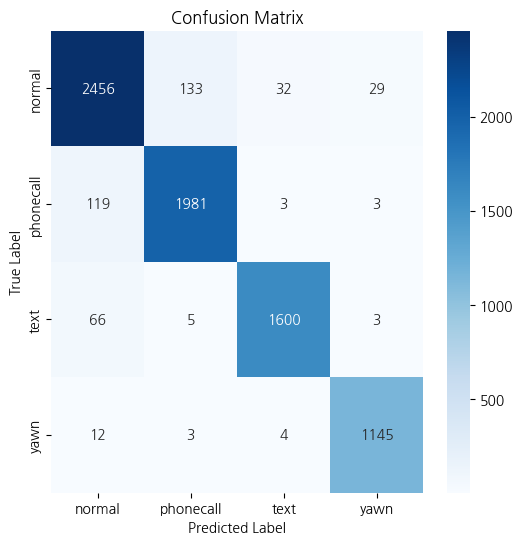


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.93      0.93      0.93      2650
   phonecall       0.93      0.94      0.94      2106
        text       0.98      0.96      0.97      1674
        yawn       0.97      0.98      0.98      1164

    accuracy                           0.95      7594
   macro avg       0.95      0.95      0.95      7594
weighted avg       0.95      0.95      0.95      7594



In [35]:
model = load_model(model,"/content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/best_model_2025-03-17.pth", device)
class_names = config['action_names']
evaluate_model(model, train_loader, class_names, save_dir=config["train_result_path"], file_name="train")

✅ Confusion Matrix saved at: /content/drive/MyDrive/DMS/data/model_results/031723_2s_sliding_fixed/train_results/test_cm.png


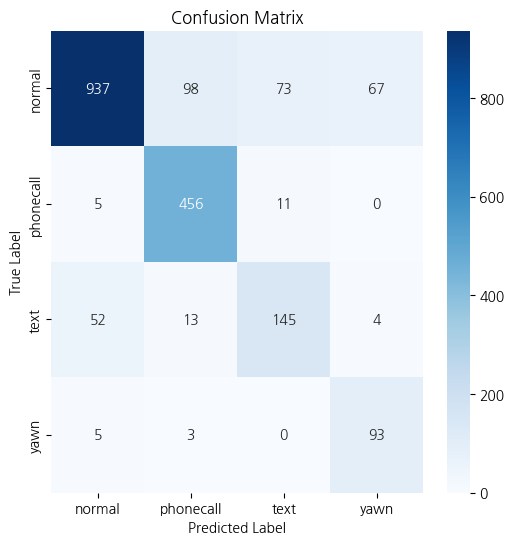


🔹 Classification Report:
              precision    recall  f1-score   support

      normal       0.94      0.80      0.86      1175
   phonecall       0.80      0.97      0.88       472
        text       0.63      0.68      0.65       214
        yawn       0.57      0.92      0.70       101

    accuracy                           0.83      1962
   macro avg       0.73      0.84      0.77      1962
weighted avg       0.85      0.83      0.83      1962



In [36]:
evaluate_model(model, test_loader, class_names, config["train_result_path"], "test")